# Task2 SEAICE TRAINING AND TEST ——PART1

### 本任务的目的是通过SEAICE数据集的训练熟悉基于UNET网络语义分割流程。
1. 用函数式构建UNET网络
2. 熟悉数据处理到模型构建-训练-预测-保存整个过程


* step1 加载必要的库函数

In [4]:
# for tf2.0
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Input,MaxPooling2D,Dropout,BatchNormalization,Conv2DTranspose,UpSampling2D,ZeroPadding2D,concatenate
from tensorflow.keras.optimizers import RMSprop,Adam
import matplotlib.pyplot as plt
import glob
import time
from sklearn.model_selection import train_test_split
from skimage import io
from historycal_tf2 import LossHistory
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


* step2 加载数据并完成预处理

In [5]:
image_path = './sea_ice\\image\\'
mask_path = './sea_ice\\label\\'
result_path = './prediction\\'
target_size = (256,256)


In [6]:
# first of all check the image format,confirm the max value (uint8 0-255)
def Load_Color_Data(image_path, mask_path):
    image_name_arr = glob.glob(os.path.join(image_path,"*.jpg"))
    image_arr = []
    mask_arr = []
    
    for index,item in enumerate(image_name_arr):
        img = io.imread(item)
        # img=np.resize(img,(256,256))
        # img = np.reshape(img,img.shape + (1,))
        # print(item,item.replace(image_path,mask_path))
        mask = io.imread(item.replace(image_path,mask_path))
        # mask=np.resize(mask,(256,256))
        # mask = np.reshape(mask,img.shape  + (1,))
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        image_arr.append(img)
        mask_arr.append(mask)

    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr, mask_arr

def plot_func(data,label):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,0])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,0]),cmap="gray")
    plt.show()

In [7]:
images, labels = Load_Color_Data(image_path, mask_path)
# images = np.reshape(images,images.shape + (1,))
labels = np.reshape(labels,labels.shape + (1,))
threshold=500
xtrain,xtest,ytrain,ytest=train_test_split(images[:threshold],labels[:threshold],test_size=0.3)
xval=images[threshold:]
yval=labels[threshold:]
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape,xval.shape,yval.shape)

(350, 256, 256, 3) (150, 256, 256, 3) (350, 256, 256, 1) (150, 256, 256, 1) (200, 256, 256, 3) (200, 256, 256, 1)


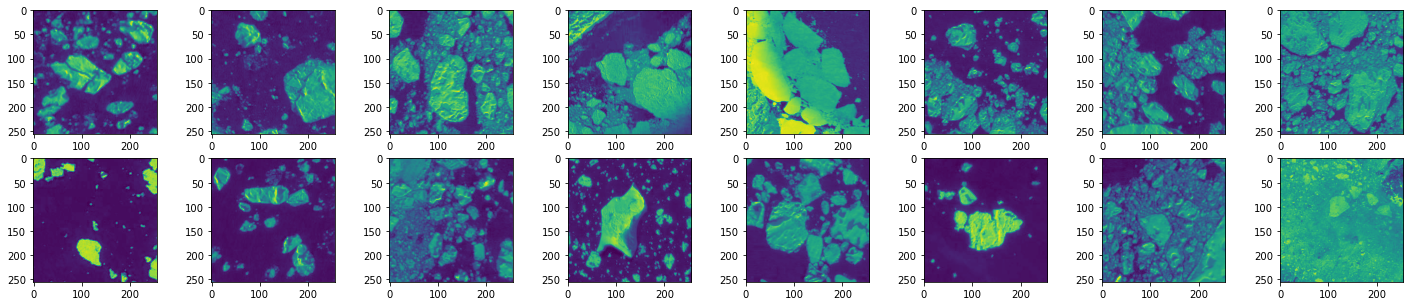

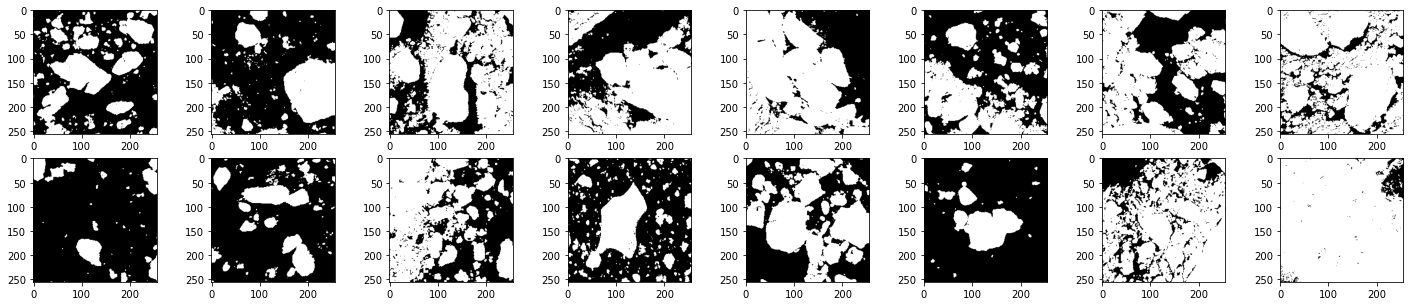

In [8]:
# Check whether the images are consistent with the labels
plot_func(xtrain,ytrain)

* step3 build UNET

In [9]:
def unet(input_size,optimizer,loss,metrics):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    # conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,outputs)

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    return model


* step4 setting hyper-params

In [10]:
loss='binary_crossentropy'
optimizer=Adam(lr=0.001)##SGD(),Adamax(),Adadelta()RAdam()
metrics=['accuracy']
input_height=256
input_width=256
nclass=1
nchannel=3
epoch=10
batch_size=40
nickname='unet'
input_size=(input_height,input_width,nchannel)
model=unet(input_size,optimizer,loss,metrics)
# model.summary()

* setp5 训练模型

In [12]:
begin_time = time.time()           
model_checkpoint = ModelCheckpoint(filepath="./checkpoint\\"+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
histories=LossHistory()
csvlogger =CSVLogger(filename="./checkpoint\\"+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,csvlogger,histories])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Epoch 1/10
9/9 [==============================] - 34s 2s/step - loss: 1.7277 - accuracy: 0.5196 - val_loss: 0.3964 - val_accuracy: 0.8878
Epoch 2/10
9/9 [==============================] - 6s 647ms/step - loss: 0.9531 - accuracy: 0.7104 - val_loss: 0.6240 - val_accuracy: 0.4563
Epoch 3/10
9/9 [==============================] - 6s 635ms/step - loss: 0.5813 - accuracy: 0.6370 - val_loss: 0.4585 - val_accuracy: 0.8988
Epoch 4/10
9/9 [==============================] - 6s 620ms/step - loss: 0.3961 - accuracy: 0.8893 - val_loss: 0.3678 - val_accuracy: 0.8257
Epoch 5/10
9/9 [==============================] - 6s 624ms/step - loss: 0.2674 - accuracy: 0.8899 - val_loss: 0.2022 - val_accuracy: 0.9230
Epoch 6/10
9/9 [==============================] - 6s 649ms/step - loss: 0.1939 - accuracy: 0.9224 - val_loss: 0.2109 - val_accuracy: 0.9236
Epoch 7/10
9/9 [==============================] - 6s 651ms/step - loss: 0.1834 - accuracy: 0.9271 - val_loss: 0.1746 - val_accuracy: 0.9353
Epoch 8/10
9/9 [======

In [ ]:
# histories.loss_plot('epoch','./')
# histories.loss_plot('batch','./')
# histories.h5_save('./history.hdf5')

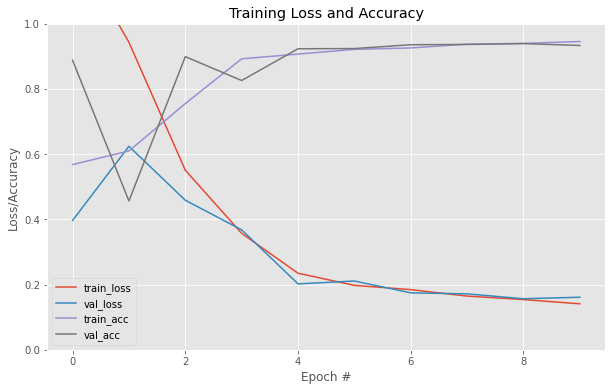

In [15]:
def plot_fig(H,outdir):
    N=len(result.history['loss'])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.ylim(0,1)

    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(outdir)
plot_fig(result,nickname+"_Loss_Acc_epoch.png")

5/5 [==============================] - 1s 182ms/step - loss: 0.1573 - accuracy: 0.9354
0.15734928846359253 0.9354202151298523


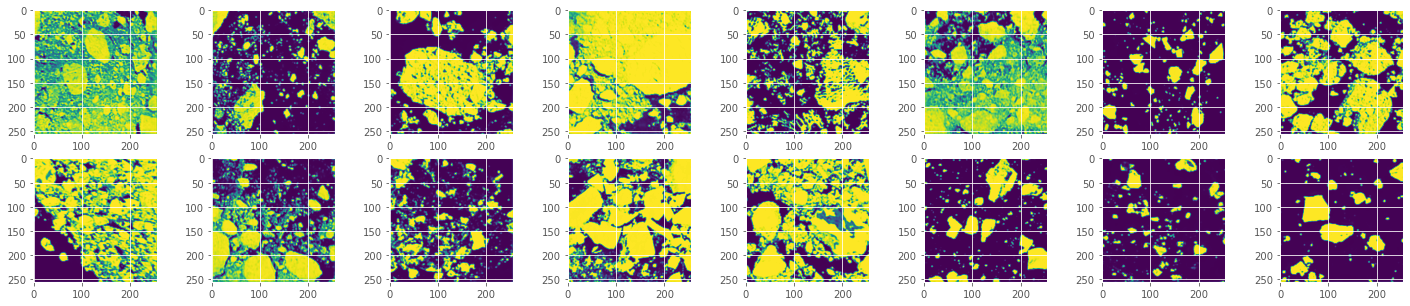

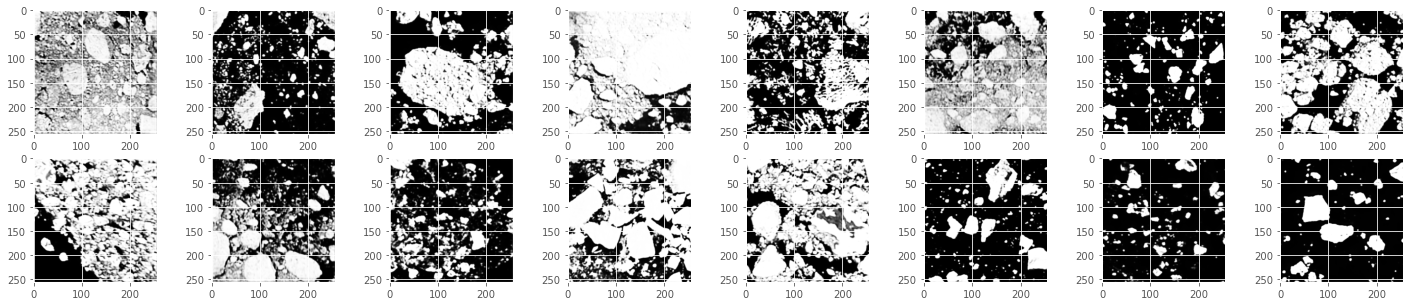

In [14]:
val_loss,val_acc=model.evaluate(x=xval,y=yval, batch_size=40, verbose=1)
print(val_loss,val_acc)
pred=model.predict(xval)
plot_func(pred,pred*255)